# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

Mounted at /content/drive/
/content/drive/My Drive/real_estate_spb
   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0   

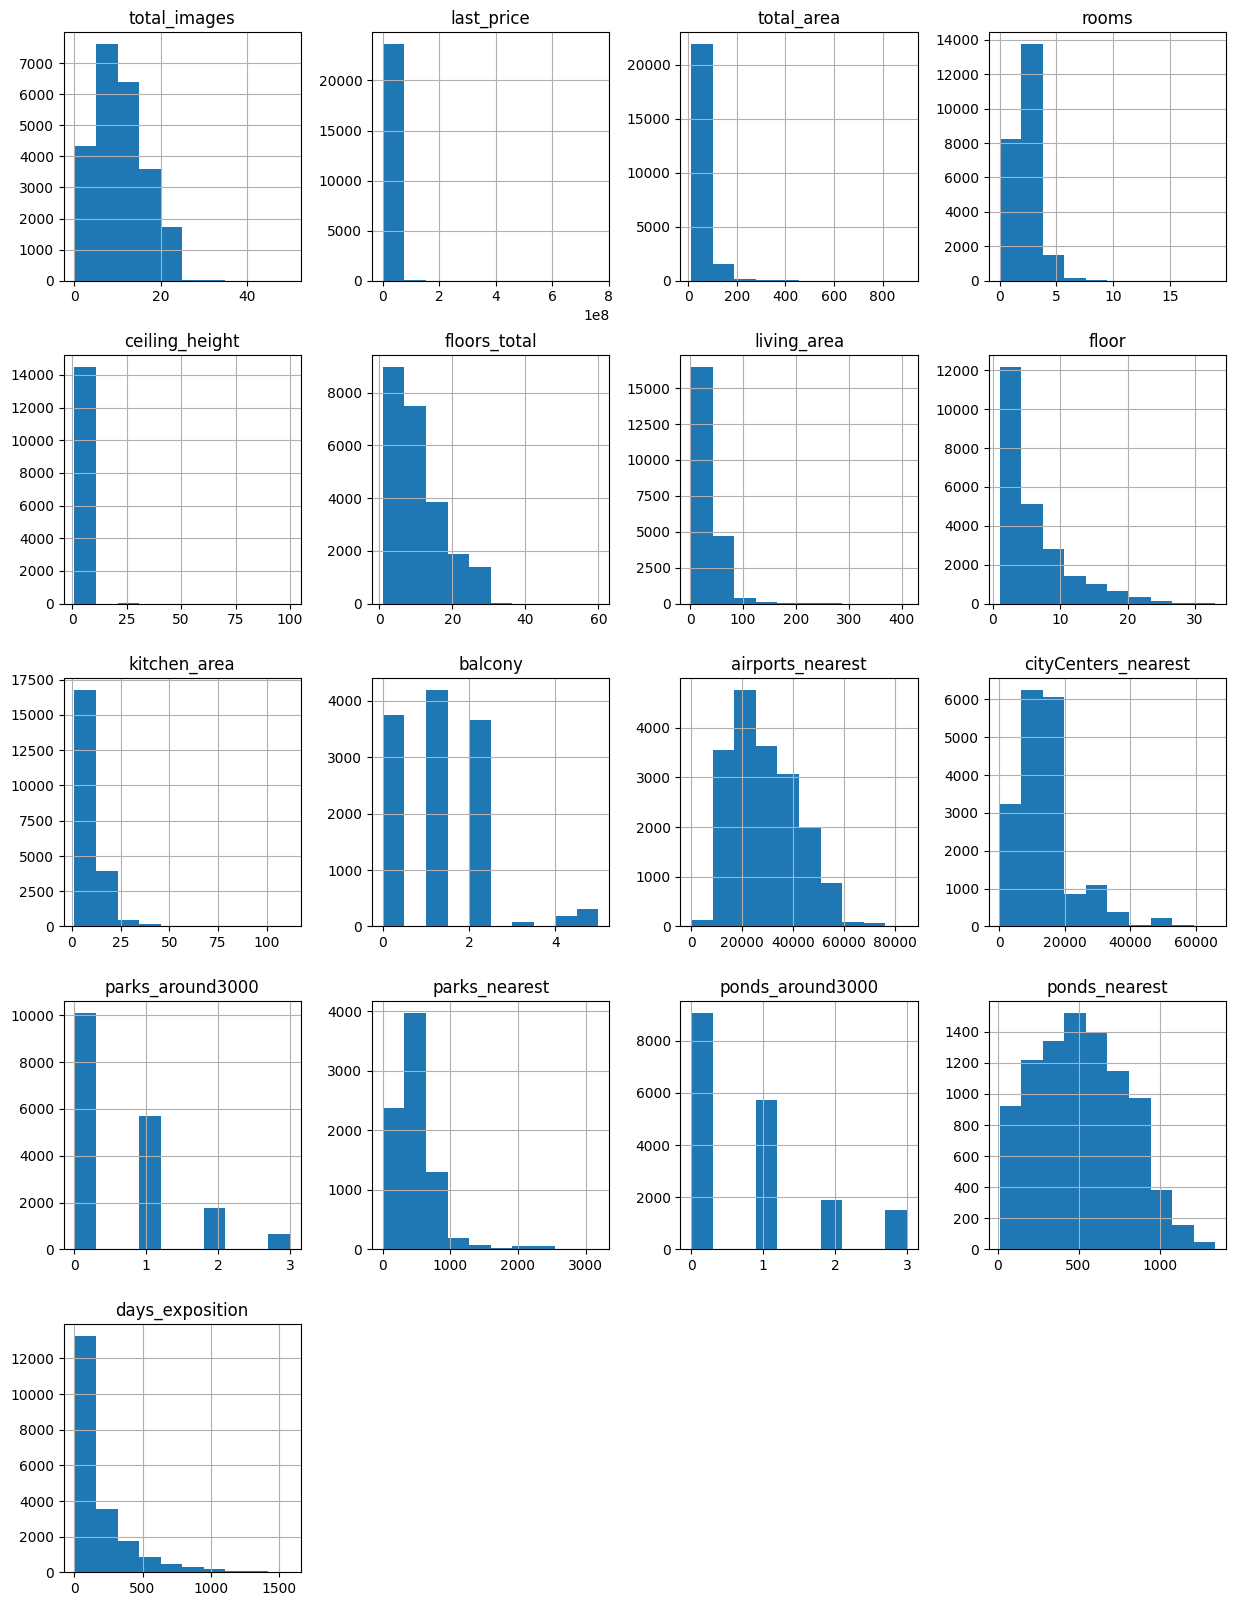

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/real_estate_spb
df = pd.read_csv('real_estate_data.csv', sep='\t')
old_data = df
print(df.head())
print (df.info())
print (df.hist(bins=10,figsize=(15,20)))

Открываю файл с данными, изучаю общую информацию о полученном датафрейме, построю гистрограммы для датафрейма и изучу их.

### Предобработка данных

Проверю наличие пропусков в DataFrame

In [6]:
print(df.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Изучив DataFrame, я вижу пропуски в следующих столбцах:


1. **ceiling_height** (высота потолков) - пропуск в данном столбце вероятно связан с незнанием пользователя высоты полотка продаваемой недвижимости. В Санкт-Петербурге и Ленобласти действуют нормативные требования «СП 54.13330.2011. Свод правил. Здания жилые многоквартирные», согласно которым высота потолков в жилых помещениях и кухнях должна быть не меньше 2,5 м.

Проверим какие данные внесены в столбец.



In [7]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медианное значение в столбце (50%) = 2,65 метра;
Минимальная высота потолка (min) = 1 метр;
Максимальная высота потолка (max) = 100 метров.
Пропуски в столбце заполню медианным значением, минимальные и максимальные значения мне пригодятся в дальнейшем для объективного анализа.

In [8]:
df ['ceiling_height']= df ['ceiling_height'].fillna(df['ceiling_height'].median())

Заполняю пропуски медианным значением. Вновь проверяем DataFrame на количество пропущенных значений.

In [9]:
print(df.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Следующий столбец, на который стоит обратить внимание это:
balcony (количество балконов) - очевидно, если клиент не указал количество балконов, то скорее всего его нет. Изменим пропущенные значения на число 0.

In [10]:
df['balcony'] = df['balcony'].fillna(0)

Следующий столбец который мне будет необходим в дальнейшем исследовании это:
days_exposition(количество дней опубликованного объявления, от публикации до продажи) Изучу его.

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

array([[<Axes: title={'center': 'days_exposition'}>]], dtype=object)

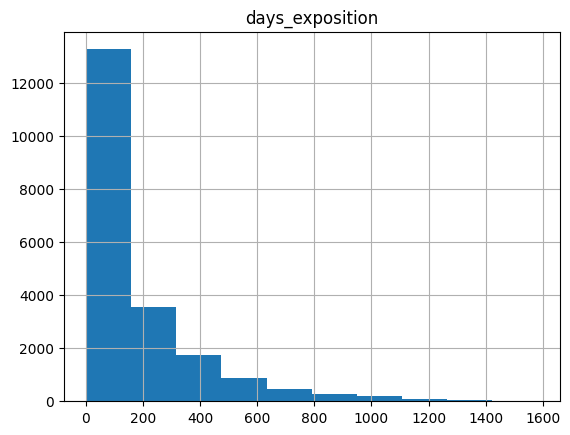

In [11]:
display(df['days_exposition'].describe())
df.hist('days_exposition')

Гистограмма выглядит корректно. Не исключено что пользователь мог продавать квартиру как 1580 дней так и 1 день.

Далее для исследования необходимо удалить пропуски в столбце Название населенного пункта. Так как пропусков всего 49, их можно удалить, небольшое количество удаленных пропусков не повлияет на ход исследования.

Проверим выполнение.

In [12]:
df = df.dropna(subset=['locality_name'])

In [13]:
print(df.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area              1898
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64


В остальных столбцах пропущенные данные оставлю как есть. В случае со столбцами:
* общее количество этажей в доме (`floors_total`),
* вид недвижимости - аппартаменты (`is_apartment`),
* число парков в радиусе 3 км (`parks_around3000`),
* расстояние до ближайшего парка (`parks_nearest`),
* число водоемов в радиусе 3 км (`ponds_around3000`),
* расстояние до ближайшего водоёма (`ponds_nearest`)
<br> не имеет смысла заполнять пропуски так как для исследования эти данные не нужны.
<br> В случае со столбцами:
* всего этажей в доме (`floors_total`)
* жилая площадь (`living_area`)
* площадь кухни (`kitchen_area`)
<br> не имеет смысла заполнять пропуски так как пропущенные данные составляют менее 10% от Датафрейма, мы не сможем заполнить медианным значением, так как география продажи недвижимости разная и выявить стандарт у нас не получится, данные пропуски не сильно повлияют на ход исследования.

Следующий этап в предобработке данных это изучение типа данных и преобразование их в нужный тип. Рассмотрим какой тип данных соответсвую каждому столбцу:

In [14]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Исходя из описания данных, видно, что, для корректного исследования, мне необходимо преобразовать некоторые типы данных столбцов.

Дата публикации объявления (`first_day_exposition`) - преобразовать в тип *datetime64*

In [15]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

<ipython-input-15-2238e7fd49a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')


Число балконов (balcony) - преобразовать в тип *int64*

In [16]:
df['balcony'] = df['balcony'].astype('int64')

<ipython-input-16-b8ab15d43363>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['balcony'] = df['balcony'].astype('int64')


Количество дней размещенного объявдения, от публикации до снятия (days_exposition) - преобразовать в *int64*

Проверю преобразования типов данных.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

Следующим этапом предобработки данных будет поиск дубликатов в столбце название населенного пункта (locality_name). Изучу уникальные значения.

In [18]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В результате я увидел некоторое количество дупликатов, для объективного исследования избавимся от наименования типа населенного пункта. Определю их в отдельный список.

In [19]:
duplicates = ['деревня ', 'поселок ', 'посёлок ', 'городского типа ', 'городской ', 'село ', 'коттеджный ',
              'при железнодорожной станции ', 'станции ', 'садовое товарищество ', 'садоводческое некоммерческое товарищество ']

Циклом пройдусь по всем значениям столбца и уберу наименования типа населенного пункта.

In [20]:
for i in duplicates:
  df['locality_name'] = df['locality_name'].str.replace(i, '')

<ipython-input-20-5a2c9c566b99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['locality_name'] = df['locality_name'].str.replace(i, '')


Посмотрю на результат

In [21]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,11.0,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,NaN,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Следующим этапом предобработки будет устранение редких и выбывающих значений столбцов.
<br>Начну со столбца "Высота потолков"  `ceiling_height`
<br>Посмотрю описание данных и график высоты потолков

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

<Axes: >

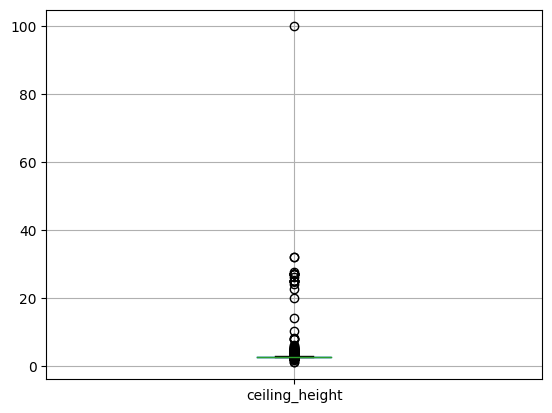

In [22]:
display (df['ceiling_height'].describe())
df.boxplot('ceiling_height')

In [23]:
display (df.query('100 > ceiling_height > 5' ))
display (df.query('ceiling_height == 100 or ceiling_height < 2' ))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
464,15,66571000.0,280.3,2015-06-11,6,5.2,8.0,159.5,7,NaN,...,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12,5,5.3,3.0,190.0,3,NaN,...,63.0,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1388,20,59800000.0,399.0,2015-01-21,5,5.6,6.0,NaN,6,NaN,...,NaN,0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,8.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,0,Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,NaN,2,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,5.5,0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,9.0,2,Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2.0,27.5,1,NaN,...,5.20,0,Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,...,8.34,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12.0,32.4,7,NaN,...,10.00,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
22869,0,15000000.0,25.0,2018-07-25,1,100.00,5.0,14.0,5,True,...,11.00,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Изучив данные, видно некоторое количество аномальных выбросов. Например высота потолков 25 и более метров. Очевидно, что в многоэтажных зданиях такой высоты быть не может. Вероятно пользователь ошибся и не поставил запятую при заполнении объявления. Исправлю это, объявления с высотой потолков свыше 24 метров разделю на 10 таким образом получу реальную высоту потолков.  

In [24]:
df.loc[df['ceiling_height'] >= 23,'ceiling_height'] = df.loc[df['ceiling_height'] >= 23,'ceiling_height'] / 10

Также есть строки в которых высота менее 2 метров и один случай с высотой 100 метров. Для объективного исследования мне от них лучше избавиться вообще.

In [25]:
df.drop(df[df['ceiling_height'] == 100].index, inplace=True)
df.drop(df[df['ceiling_height'] <= 2].index, inplace=True)

<ipython-input-25-94db07b98215>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['ceiling_height'] == 100].index, inplace=True)
<ipython-input-25-94db07b98215>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['ceiling_height'] <= 2].index, inplace=True)


Остались также потолки с аномальной высотой более 5 метров

In [26]:
df.query('ceiling_height > 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
464,15,66571000.0,280.3,2015-06-11,6,5.2,8.0,159.5,7,NaN,...,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12,5,5.3,3.0,190.0,3,NaN,...,63.0,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1388,20,59800000.0,399.0,2015-01-21,5,5.6,6.0,NaN,6,NaN,...,NaN,0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,0,Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,8.3,1,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
7578,17,38000000.0,143.0,2017-11-02,3,5.5,5.0,83.0,5,NaN,...,29.0,1,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
12628,14,3900000.0,50.0,2018-03-29,1,5.3,5.0,NaN,5,NaN,...,NaN,0,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14.0,32.4,5,NaN,...,9.1,2,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,8.0,0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,...,NaN,1,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0


Удалю эти строки.

In [27]:
df.drop(df[df['ceiling_height'] >= 5].index, inplace=True)

<ipython-input-27-a4be659b6cf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['ceiling_height'] >= 5].index, inplace=True)


Посмотрю аномальные выбросы в столбце "Цена на момент снятия с публикации" (`last_price`)

Для понимания, исправлю формат отображения функции describe()

In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [29]:
df['last_price'].describe()

count       23619.00
mean      6526182.78
std      10820695.24
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6799000.00
max     763000000.00
Name: last_price, dtype: float64

Минимальная цена за недвижимость 12190. Посмотрю 5 самых низких предложений.

In [30]:
df.sort_values('last_price').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.00,109.00,2019-03-20,2,2.75,25.00,32.00,25,NaN,...,40.50,0,Санкт-Петербург,36421.00,9176.00,1.00,805.00,0.00,NaN,8.00
17456,7,430000.00,30.40,2019-04-22,1,2.65,2.00,16.00,1,NaN,...,6.00,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000.00,54.00,2018-06-26,2,2.65,3.00,NaN,3,NaN,...,NaN,0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.00
16274,18,440000.00,40.00,2018-07-10,1,2.65,5.00,NaN,1,NaN,...,NaN,0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.00
5698,7,450000.00,42.00,2017-07-31,2,2.65,1.00,23.00,1,NaN,...,5.80,0,Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.00


Стоимость квартиры в Санкт-Петербурге за 12190, да ещё и за площадь 109 кв.м. смущает. А в населенных пунктах: Сланцы, Свирь, Старополье и Будогощь вполне вероятно. Стоит также отметить что года продаж 2017-2019. Удалим объявление о продаже квартиры в Санкт-Петербурге за 12190.

In [31]:
df.drop(df[df['last_price'] == 12190.0].index, inplace=True)

<ipython-input-31-ac8c63e24fb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['last_price'] == 12190.0].index, inplace=True)


Проверю выполненное.

In [32]:
df.sort_values('last_price').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14911,5,430000.00,54.00,2018-06-26,2,2.65,3.00,NaN,3,NaN,...,NaN,0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.00
17456,7,430000.00,30.40,2019-04-22,1,2.65,2.00,16.00,1,NaN,...,6.00,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16274,18,440000.00,40.00,2018-07-10,1,2.65,5.00,NaN,1,NaN,...,NaN,0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.00
16219,14,450000.00,38.50,2018-07-11,2,2.65,2.00,NaN,1,NaN,...,NaN,0,Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.00
17676,0,450000.00,36.50,2018-02-01,1,2.65,5.00,17.30,4,NaN,...,8.50,1,Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.00


С минимальными значениями разобрались, посмотрю какие данные на максимальных значениях.

In [33]:
df.sort_values('last_price',ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.00,400.00,2017-09-30,7,2.65,10.00,250.00,10,NaN,...,NaN,2,Санкт-Петербург,25108.00,3956.00,1.00,530.00,3.00,756.00,33.00
19540,8,420000000.00,900.00,2017-12-06,12,2.80,25.00,409.70,25,NaN,...,112.00,0,Санкт-Петербург,30706.00,7877.00,0.00,NaN,2.00,318.00,106.00
14706,15,401300000.00,401.00,2016-02-20,5,2.65,9.00,204.00,9,False,...,24.00,3,Санкт-Петербург,21912.00,2389.00,1.00,545.00,1.00,478.00,393.00
1436,19,330000000.00,190.00,2018-04-04,3,3.50,7.00,95.00,5,NaN,...,40.00,0,Санкт-Петербург,23011.00,1197.00,3.00,519.00,3.00,285.00,233.00
15651,20,300000000.00,618.00,2017-12-18,7,3.40,7.00,258.00,5,NaN,...,70.00,0,Санкт-Петербург,32440.00,5297.00,0.00,NaN,2.00,198.00,111.00


Стоимость квартир с площадью более 400 кв.м. в 3 км от центра города Санкт-Петербург выглядят логично и без ошибок. Проверю цены квартир со следующими параметрами: квартиры не в городе Санкт-Петербург, менее 100 кв.м. и дороже 10 млн.

In [34]:
df.query('locality_name != "Санкт-Петербург" and total_area < 100 and last_price >= 10000000' ).sort_values('last_price',ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21238,1,24412900.00,38.12,2018-06-27,1,2.65,10.00,16.83,4,False,...,10.70,1,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,44.00
15037,9,23000000.00,71.00,2017-05-15,2,3.30,4.00,31.00,2,False,...,24.50,2,Зеленогорск,70016.00,51115.00,0.00,NaN,0.00,NaN,90.00
14185,10,17212500.00,76.50,2015-09-03,2,2.65,4.00,30.20,2,NaN,...,23.90,0,Зеленогорск,70016.00,51115.00,0.00,NaN,0.00,NaN,NaN
15582,20,16990000.00,93.00,2017-11-08,3,3.10,4.00,49.00,3,NaN,...,14.00,2,Сестрорецк,58290.00,35219.00,2.00,633.00,1.00,320.00,30.00
3773,20,15300000.00,92.20,2019-03-14,3,4.00,4.00,55.80,4,NaN,...,14.80,1,Сестрорецк,53952.00,35051.00,0.00,NaN,0.00,NaN,NaN
12466,11,15000000.00,89.60,2017-01-31,3,2.65,3.00,57.00,3,NaN,...,13.50,0,Пушкин,15065.00,27218.00,3.00,317.00,3.00,509.00,357.00
11499,20,14500000.00,97.80,2018-03-06,3,2.55,4.00,68.80,2,NaN,...,13.10,0,Пушкин,14014.00,26167.00,1.00,609.00,0.00,NaN,256.00
6641,20,13900000.00,95.00,2019-03-11,4,2.65,3.00,68.00,2,NaN,...,14.50,0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13295,20,13333000.00,84.00,2017-02-07,2,2.65,4.00,42.00,3,NaN,...,16.00,1,Сестрорецк,58290.00,35219.00,2.00,633.00,1.00,320.00,64.00
21646,20,12800000.00,79.80,2019-03-23,3,2.80,14.00,43.00,2,NaN,...,12.00,2,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Взгляну также на диаграмму размаха.

<Axes: >

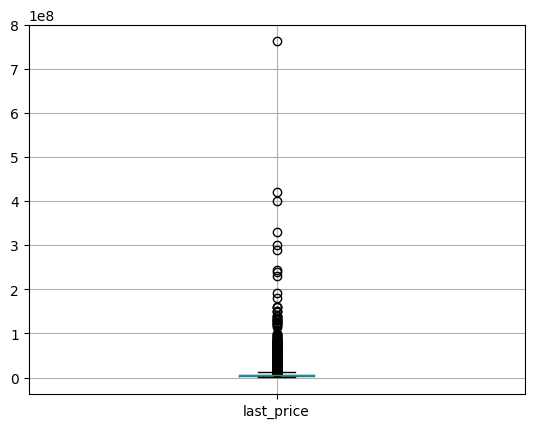

In [35]:
df.boxplot('last_price')

Удалю аномально дорогие квартиры, их природа ясна и понятна, однако для лучшей интерпретации удалений аномально дорогих квартир, поможет нам более точно выявить закономерности в данных.

In [36]:
df.drop(df[df['last_price'] >= 15000000].index, inplace=True)

<ipython-input-36-afe45c90b8c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['last_price'] >= 15000000].index, inplace=True)


<Axes: >

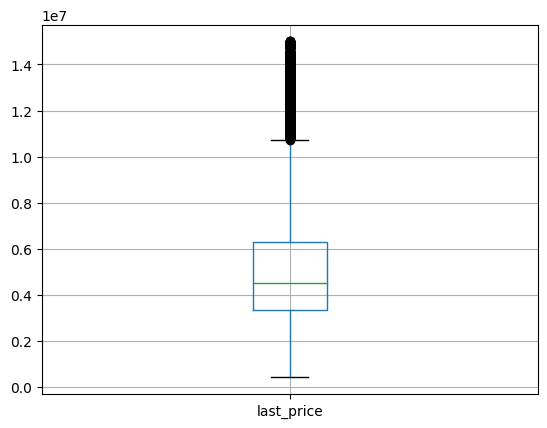

In [37]:
df.boxplot('last_price')

Посмотрю на аномальный выброс количества комнат.

<Axes: >

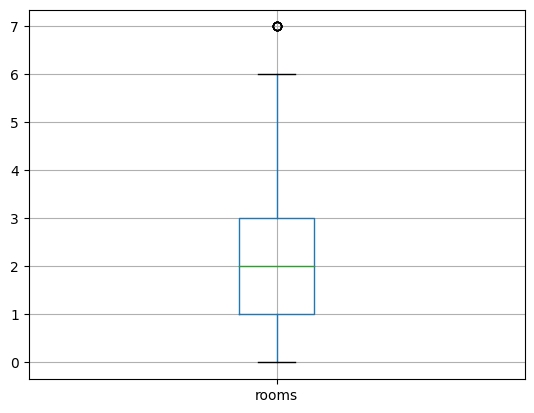

In [38]:
df.boxplot('rooms')

In [39]:
df.drop(df[df['rooms'] >= 7].index, inplace=True)

<ipython-input-39-23dc6a19273c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['rooms'] >= 7].index, inplace=True)


Посмотрю полученный результат.

In [40]:
df['rooms'].describe()

count   22376.00
mean        1.97
std         0.94
min         0.00
25%         1.00
50%         2.00
75%         3.00
max         6.00
Name: rooms, dtype: float64

Следующий столбец который я изучу это общая площадь недвижимости.

<Axes: >

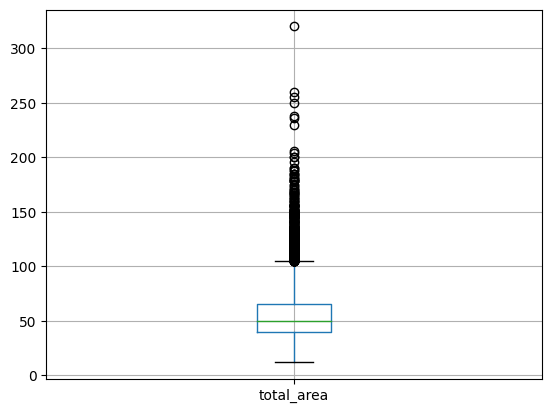

In [41]:
df.boxplot('total_area')

Большое количество аномальных выбросов.

In [42]:
df.drop(df[df['total_area'] >= 99].index, inplace=True)

<ipython-input-42-f514b0fdc4d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['total_area'] >= 99].index, inplace=True)


<Axes: >

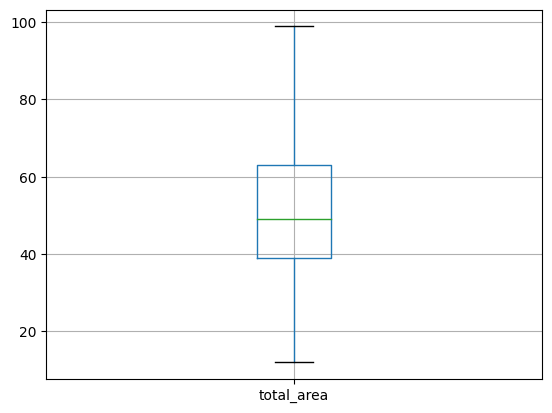

In [43]:
df.boxplot('total_area')

Проверю объем удаленных данных.

In [44]:
new_data = df

In [45]:
new_data.shape[0] / old_data.shape[0]

0.9051858728216381

#Промежуточный итог:
<br> Изучив DataFrame я преступил к предобработке данных. Определил пропуски в столбцах. Определил в каких столбцах на необходимо заполнить или удалить пропуски. Изменил тип данных в некоторых столбцах для дальнейшего объективного анализа. Убрал неявные дубликаты в столбце с названиями населенных пунктов. Нашел и устранил редкие и выбивающие значения в нужных для исследования столбцах. Следующим шагом для исследования будет создание новых столбцов. Посчитаю и добавлю столбец: цена одного квадратного метра. Для этого разделю столбец цены на момент снятия публикации на общую площадь недвижимости.

In [46]:
df['square_meter_price'] = df['last_price']/df['total_area']

<ipython-input-46-8519cac5216d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_meter_price'] = df['last_price']/df['total_area']


Посмотрю результат.

In [47]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price
1,7,3350000.00,40.40,2018-12-04,1,2.65,11.00,18.60,1,NaN,...,2,Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00,82920.79
2,10,5196000.00,56.00,2015-08-20,2,2.65,5.00,34.30,4,NaN,...,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,92785.71
5,10,2890000.00,30.40,2018-09-10,1,2.65,12.00,14.40,5,NaN,...,0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00,95065.79
6,6,3700000.00,37.30,2017-11-02,1,2.65,26.00,10.60,6,NaN,...,1,Парголово,52996.00,19143.00,0.00,NaN,0.00,NaN,155.00,99195.71
7,5,7915000.00,71.60,2019-04-18,2,2.65,24.00,NaN,22,NaN,...,2,Санкт-Петербург,23982.00,11634.00,0.00,NaN,0.00,NaN,NaN,110544.69


Стоимость за квадратный метр недвижимости можно было сделать более подробным для Санкт-Петербурга и Ленинградской области, однако некоторые населенные пункты например город Пушкин находится в городском округе Санкт-Петербурга, и там представлено более дорогой ценой за квадратный метр, чем в Ленинградской области. Для объективности необходимо указывать, что населенный пункт находится в городском округе города Санкт-Петербурга.
<br>Следующий столбец, который я создам это: день недели, месяц и год публикации объявления. Для этого применим метод `dt.weekday`, `dr.month` и `dt.year` к столбцу "Первый день публикации объявления".

In [48]:
df['day_expo'] = df['first_day_exposition'].dt.weekday
df['month_expo'] = df['first_day_exposition'].dt.month
df["year_expo"] = df["first_day_exposition"].dt.year

<ipython-input-48-ba31354706fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_expo'] = df['first_day_exposition'].dt.weekday
<ipython-input-48-ba31354706fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_expo'] = df['first_day_exposition'].dt.month
<ipython-input-48-ba31354706fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Проверю результат.

In [49]:
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_expo,month_expo,year_expo
1,7,3350000.00,40.40,2018-12-04,1,2.65,11.00,18.60,1,NaN,...,18603.00,0.00,NaN,0.00,NaN,81.00,82920.79,1,12,2018
2,10,5196000.00,56.00,2015-08-20,2,2.65,5.00,34.30,4,NaN,...,13933.00,1.00,90.00,2.00,574.00,558.00,92785.71,3,8,2015
5,10,2890000.00,30.40,2018-09-10,1,2.65,12.00,14.40,5,NaN,...,NaN,NaN,NaN,NaN,NaN,55.00,95065.79,0,9,2018
6,6,3700000.00,37.30,2017-11-02,1,2.65,26.00,10.60,6,NaN,...,19143.00,0.00,NaN,0.00,NaN,155.00,99195.71,3,11,2017
7,5,7915000.00,71.60,2019-04-18,2,2.65,24.00,NaN,22,NaN,...,11634.00,0.00,NaN,0.00,NaN,NaN,110544.69,3,4,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000.00,62.40,2016-08-05,3,2.60,9.00,40.00,8,NaN,...,34104.00,1.00,352.00,1.00,675.00,239.00,73717.95,4,8,2016
23695,14,3100000.00,59.00,2018-01-15,3,2.65,5.00,38.00,4,NaN,...,NaN,NaN,NaN,NaN,NaN,45.00,52542.37,0,1,2018
23696,18,2500000.00,56.70,2018-02-11,2,2.65,3.00,29.70,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44091.71,6,2,2018
23697,13,11475000.00,76.75,2017-03-28,2,3.00,17.00,NaN,12,NaN,...,10364.00,2.00,173.00,3.00,196.00,602.00,149511.40,1,3,2017


Следующий столбец, который я создам это тип этажа недвижимости. Сделаю это через функцию `def`

In [50]:
def flat_type_check (row):
    floor = row['floor']
    floors_total = row['floors_total']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        return

df['flat_type'] = df.apply(flat_type_check, axis=1)

<ipython-input-50-6d69eff778a2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flat_type'] = df.apply(flat_type_check, axis=1)


Также создам новый столбец "Расстояние до центра города в километрах" оператором деления "/".

In [51]:
df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).round()

<ipython-input-51-07e3a49988cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).round()


Проверю выполненное.

In [52]:
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_expo,month_expo,year_expo,flat_type,cityCenters_nearest_km
1,7,3350000.00,40.40,2018-12-04,1,2.65,11.00,18.60,1,NaN,...,NaN,0.00,NaN,81.00,82920.79,1,12,2018,первый,19.00
2,10,5196000.00,56.00,2015-08-20,2,2.65,5.00,34.30,4,NaN,...,90.00,2.00,574.00,558.00,92785.71,3,8,2015,другой,14.00
5,10,2890000.00,30.40,2018-09-10,1,2.65,12.00,14.40,5,NaN,...,NaN,NaN,NaN,55.00,95065.79,0,9,2018,другой,NaN
6,6,3700000.00,37.30,2017-11-02,1,2.65,26.00,10.60,6,NaN,...,NaN,0.00,NaN,155.00,99195.71,3,11,2017,другой,19.00
7,5,7915000.00,71.60,2019-04-18,2,2.65,24.00,NaN,22,NaN,...,NaN,0.00,NaN,NaN,110544.69,3,4,2019,другой,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000.00,62.40,2016-08-05,3,2.60,9.00,40.00,8,NaN,...,352.00,1.00,675.00,239.00,73717.95,4,8,2016,другой,34.00
23695,14,3100000.00,59.00,2018-01-15,3,2.65,5.00,38.00,4,NaN,...,NaN,NaN,NaN,45.00,52542.37,0,1,2018,другой,NaN
23696,18,2500000.00,56.70,2018-02-11,2,2.65,3.00,29.70,1,NaN,...,NaN,NaN,NaN,NaN,44091.71,6,2,2018,первый,NaN
23697,13,11475000.00,76.75,2017-03-28,2,3.00,17.00,NaN,12,NaN,...,173.00,3.00,196.00,602.00,149511.40,1,3,2017,другой,10.00


# Промежуточный итог:
<bt> На данном этапе я добавил новые столбцы, сформировал новые группы по годам, дням неделям и месяцам, укрупнил группы этажей недвижимости в объявлениях. Перевел расстояния из метров в километры и округлил до целых чисел.Все готово для исследования таблицы.

Изучу общую площадь всех объявлений Датафрейма:

count   21452.00
mean       52.34
std        17.00
min        12.00
25%        39.00
50%        49.00
75%        63.00
max        98.90
Name: total_area, dtype: float64

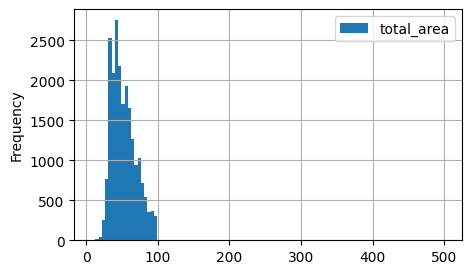

In [53]:
df.plot(y = 'total_area', kind = 'hist', bins = 108, grid=True, figsize = (5,3), range = (8,500))
df['total_area'].describe()

Исходя из гистограммы, вижу, что большинство недвижимости, которое есть в таблице имеют площадь в диапазоне от 50 до 100 кв.м., у недвижимости с площадью менее 50 кв. м. так же большая доля. В 10 раз меньше квартир с площадью от 100 до 150 кв.м. Еще меньше квартир с площадью 150 - 200 кв.м. и единичные случаи присутсвия объявления о продаже недвижмости с площадью более 200 кв.м.
<br> Посмотрю на гистограмму с жилой площадью объявлений датафрейма.

count   19776.00
mean       29.92
std        12.24
min         2.00
25%        18.00
50%        29.00
75%        39.00
max        88.00
Name: living_area, dtype: float64

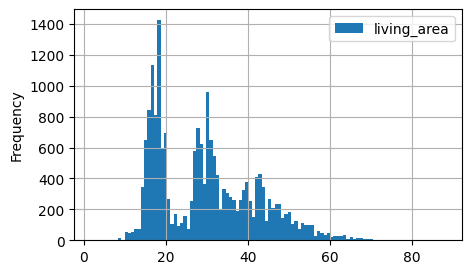

In [54]:
df.plot(y = 'living_area', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['living_area'].describe()

На гистограмме видно, что более 10 тысяч объявлений размещены с жилой площадью недвижимости с площадью до 30 кв.м. Чуть более 8 тысяч с площадью от 30 до 50 кв.м. И почти 3 тысячи объявлений с площадью 50-100 кв.м. А также небольшое количество с жилой площадью 100-150 кв.м. И единичные случаи с жилой площадью 150-200 кв.м.

count   19394.00
mean        9.59
std         3.80
min         1.30
25%         7.00
50%         9.00
75%        11.00
max        50.00
Name: kitchen_area, dtype: float64

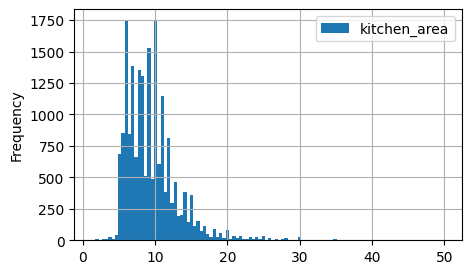

In [55]:
df.plot(y = 'kitchen_area', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['kitchen_area'].describe()

На гистограмме по площади кухни видно, что более 11 тысяч объявлений о продаже жилья с площадью кухни 5-40 кв.м. Чуть более 9 тысяч объявлений площадью кухонь от 10 до 30 кв.м. И лишь немного, около 400 объявлений с кухнями площадью от 30 до 50 кв.м. В совокупности видно нормальную пропорциональность по отношению между общей, жилой площади и площади кухонь.

Для наглядности гистограммы с ценой объектов я разделю стоимость всех объектов на 1 млн.

In [56]:
df['disp_last_price'] = df['last_price']/1000000

<ipython-input-56-198a49053410>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disp_last_price'] = df['last_price']/1000000


<Axes: title={'center': 'Стоимость объектов'}, ylabel='Frequency'>

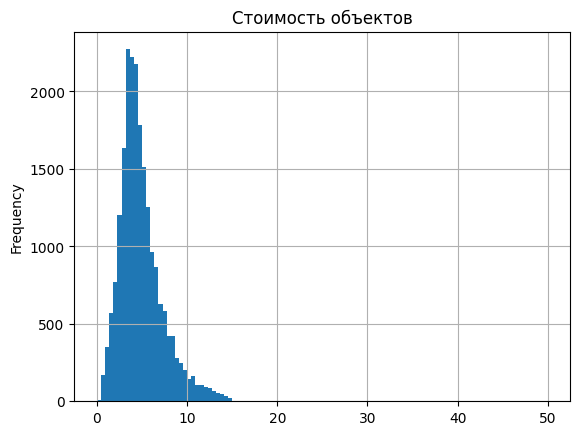

In [57]:
df['disp_last_price'].plot.hist(title = 'Стоимость объектов', grid=True, bins = 110, range = (0,50))

На гистрограмме стоимости объектов видно, что свыше 2000 объявлений с ценой порядка 4 млн.р. Это самая популярная стоимость датафрейма. Объявлений о продаже недвижимости со стоимостью выше 10 млн.р. не так много, совсем единичные случаи объявлений с ценой от 20 до 30 млн. В целом гистограмма нормального распределения.

count   21452.00
mean        1.90
std         0.87
min         0.00
25%         1.00
50%         2.00
75%         3.00
max         6.00
Name: rooms, dtype: float64

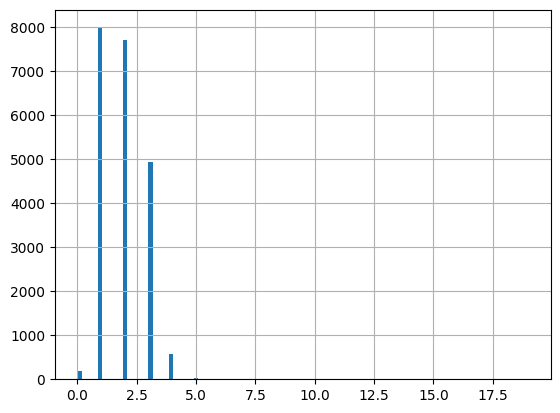

In [58]:
df['rooms'].hist(bins=108,range= (0,19))
df['rooms'].describe()

В данной гистограмме присутсвуют объявления о продаже квартир без комнат, вероятно пользователи таким образом обозначали квартиры-студии. Большое количество объявлений о продаже недвижимости (порядка 8000) квартиры с 1 и 2 комнатами. Чуть меньше (почти 6000) 3 комнатных квартир. Как мы видим присутсвуют и квартиры с 19 комнатами. Посмотрим сколько квартир с большим количеством комнат. Сделаю запрос сколько объявлений о продаже квартир с более чем 12-ью комнатами.

In [59]:
df.query('rooms >= 12')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_expo,month_expo,year_expo,flat_type,cityCenters_nearest_km,disp_last_price


6 объявлений о продаже квартир с более 12-ью комнатами, никаких аномалий тут нет, площадь квартир действительно позволяет разместить 12 и более комнат.

Следующий параметр, который я исследую, это высота потолков.

count   21452.00
mean        2.67
std         0.18
min         2.20
25%         2.60
50%         2.65
75%         2.70
max         4.80
Name: ceiling_height, dtype: float64

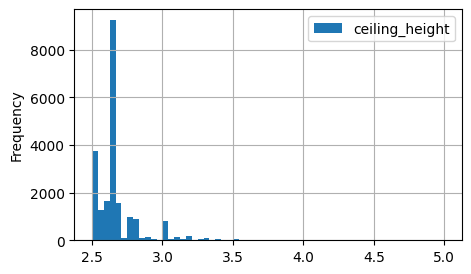

In [60]:
df.plot(y = 'ceiling_height', kind = 'hist', bins = 60, grid=True, figsize = (5,3), range= (2.5,5))
df['ceiling_height'].describe()

Большое количество объявлений с медианной высотой потолков, вероятно большое количество пропусков, которое я заменил на медианное значение повлияло на этот показатель.

Следующий параметр который мы исследуем это этаж на котором расположена продавамая недвижимость.

count   21452.00
mean        5.92
std         4.91
min         1.00
25%         2.00
50%         4.00
75%         8.00
max        31.00
Name: floor, dtype: float64

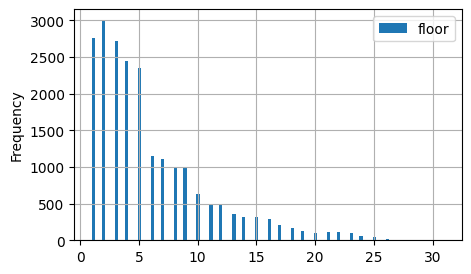

In [61]:
df.plot(y = 'floor', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['floor'].describe()

Большое количество объявлений о продаже недвижимости на первых 5 этажах, вероятно высокая доля типовых застроек ("хрущевок)"

Гляну на гистограмму по типу этажей: первый, последний и другие.

<Axes: >

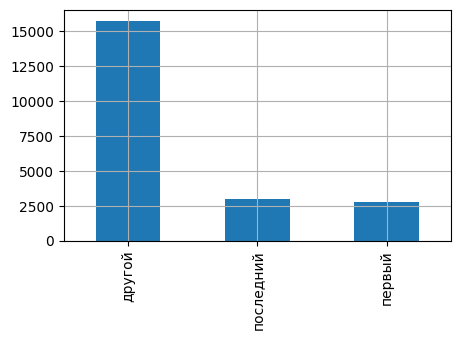

In [62]:
amount_flat_type = df['flat_type'].value_counts()
amount_flat_type.plot( kind = 'bar', grid=True, figsize = (5,3))

Большая доля объявлений о продаже недвижимости, приходится не на первый и не на последний этаж. Объявления о продаже квартир на первых и последних этажах примерно одинаковое - 2500-3000 объявлений.

Следующий параметр который я исследую это общее количество этажей в доме, где расположена продавамая недвижимость.

count   21378.00
mean       10.82
std         6.63
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

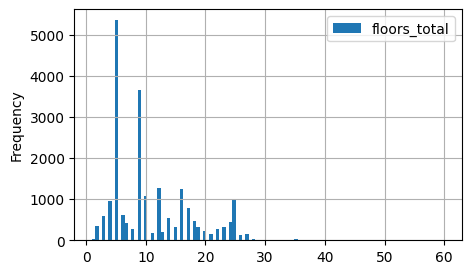

In [63]:
df.plot(y = 'floors_total', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['floors_total'].describe()

Здесь видно, что почти 6000 объявлений о продаже недвижимости, которая расположена в 5-ти этажных домах.Также большое количество объявлений о продаже квартир в 9-ти этажных домах.

Следующий параметр который я исследую это близость до центра.

count   16041.00
mean    14935.93
std      8463.72
min       208.00
25%     10603.00
50%     13587.00
75%     16685.00
max     65968.00
Name: cityCenters_nearest, dtype: float64

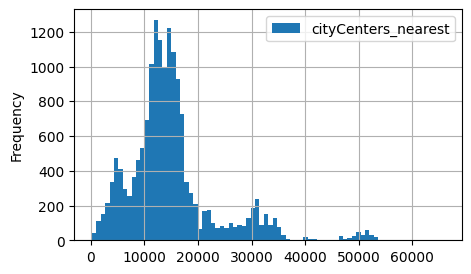

In [64]:
df.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 80, grid=True, figsize = (5,3))
df['cityCenters_nearest'].describe()

Большинство квартир, которые продаются, расположены в радиусе 10-20 км. от центра, также не мало квартир которые продаются в 5 км от центра города. Присутсвует также недвижимость которая продается в более чем 30 км. от центра города. Посмотрю подробнее на эти объявления.

In [65]:
df.query('cityCenters_nearest > 30000')['locality_name']

11          Ломоносов
13           Петергоф
14             Пушкин
28             Пушкин
33            Колпино
             ...     
23660    Красное Село
23667      Сестрорецк
23669         Колпино
23685       Ломоносов
23693        Петергоф
Name: locality_name, Length: 1259, dtype: object

Все населенные пункты, в которых расположены продаваемые квартиры, находятся в составе города Санкт-Петербург. Не исключено что до центра Санкт-Петербурга расстояние свыше 30 км, стоит также учесть что данные картографические не заполняются пользователем.

Следующий параметр который я исследую это близость до аэропорта.

count   16028.00
mean    28934.11
std     12994.20
min         0.00
25%     18030.50
50%     27244.00
75%     37715.00
max     84869.00
Name: airports_nearest, dtype: float64

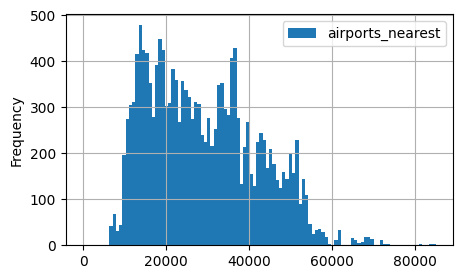

In [66]:
df.plot(y = 'airports_nearest', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['airports_nearest'].describe()

Единственным гражданским аэропортом в Санкт-Петербурге и области является аэропорт Пулково. Очевидно что некоторые населенные пункты,где продается недвижимость, находятся на расстоянии более чем 50 км. от аэропорта. Также присутсвует минимальное значение это 0, вероятно это техническая ошибка.

count   6713.00
mean     492.25
std      335.23
min        1.00
25%      291.00
50%      458.00
75%      616.00
max     3190.00
Name: parks_nearest, dtype: float64

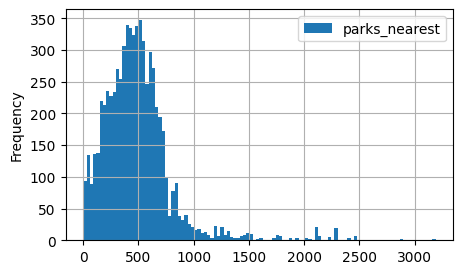

In [67]:
df.plot(y = 'parks_nearest', kind = 'hist', bins = 108, grid=True, figsize = (5,3))
df['parks_nearest'].describe()

Большое количество недвижимости продается лишь в полукилометре от парков. В целом количество объявлений о продаже квартир с рядом расположенным парком больше чем количество объявлений которые расположены дальше чем 500 м. от парка.

Рассмотрю гистрограмму по месяцам публикации объявлений.

In [68]:
df.query('parks_nearest < 750')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_expo,month_expo,year_expo,flat_type,cityCenters_nearest_km,disp_last_price
2,10,5196000.00,56.00,2015-08-20,2,2.65,5.00,34.30,4,NaN,...,2.00,574.00,558.00,92785.71,3,8,2015,другой,14.00,5.20
10,5,5050000.00,39.60,2017-11-16,1,2.67,12.00,20.30,3,NaN,...,2.00,553.00,137.00,127525.25,3,11,2017,другой,14.00,5.05
13,20,3550000.00,42.80,2017-07-01,2,2.56,5.00,27.00,5,NaN,...,3.00,298.00,366.00,82943.93,5,7,2017,последний,33.00,3.55
15,16,4650000.00,39.00,2017-11-18,1,2.65,14.00,20.50,5,NaN,...,1.00,296.00,19.00,119230.77,5,11,2017,другой,14.00,4.65
16,11,6700000.00,82.00,2017-11-23,3,3.05,5.00,55.60,1,NaN,...,0.00,NaN,397.00,81707.32,3,11,2017,первый,11.00,6.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,8,3300000.00,31.00,2017-04-29,1,2.55,9.00,18.00,6,NaN,...,1.00,317.00,193.00,106451.61,5,4,2017,другой,12.00,3.30
23689,13,3550000.00,35.30,2018-02-28,1,2.86,15.00,16.30,4,NaN,...,2.00,652.00,29.00,100566.57,2,2,2018,другой,16.00,3.55
23690,3,5500000.00,52.00,2018-07-19,2,2.65,5.00,31.00,2,NaN,...,0.00,NaN,15.00,105769.23,3,7,2018,другой,6.00,5.50
23693,9,4600000.00,62.40,2016-08-05,3,2.60,9.00,40.00,8,NaN,...,1.00,675.00,239.00,73717.95,4,8,2016,другой,34.00,4.60


<Axes: ylabel='Frequency'>

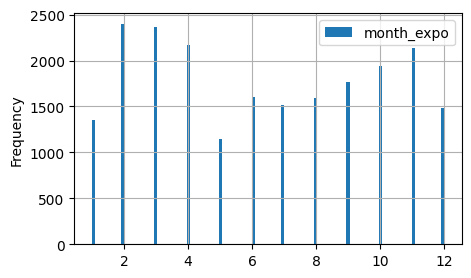

In [69]:
df.plot(y = 'month_expo', kind = 'hist', bins = 108, grid=True, figsize = (5,3))

Низкие показатели в январе, мае и декабре. Вероятно это связано с длительнными январскими и майскими праздниками. Самые же высокие показатели до и после этих месяцев.Также можно отметить просадку публикации объявлений в летний период.

Рассмотрю гистрограмму по дням неделям публикации объявлений.

<Axes: ylabel='Frequency'>

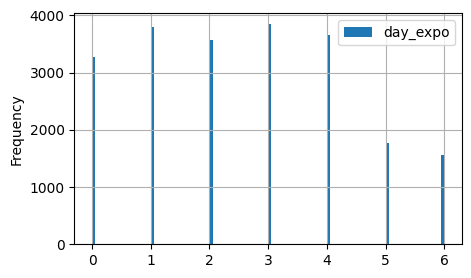

In [70]:
df.plot(y = 'day_expo', kind = 'hist', bins = 108, grid=True, figsize = (5,3))

Исходя из гистограммы видно, что в выходные дни объявления публикуют меньше всего.

### Промежуточные итоги:
<br> В ходе исследования столбцов были выявлены следующие наблюдения:
*   30 % опубликованных объявлений имеют общую площадь 50-100 кв.м.;

*   45 % опубликованных объявлений жилая площадь составляет менее 30 кв.м.;

*   46 % опубликованных объявлений площадь кухни составляет менее 40 кв.м.;

*   28 % опубликованных объявлений имеют стоимость до 5 млн.р.;

*   40 % опубликованных объявлений имеют 1 или 2 комнаты;

*   25 % опубликованных объявлений имеют 3-комнатные квартиры;

*   у 61 % опубликованных объявлений квартиры расположены на первых 5-ти этажах дома;

*   у 11 % опубликованных объявлений недвижимость расположена на 1-ом этаже;

*   13 % опубликованных объявлений квартир, которые расположены на последнем этаже;
*   у 25 % опубликованных объявлений квартиры продаются в 5-ти этажных домах


*   у  16 % опубликованных объявлений квартиры продаются в 9-ти этажных домах;


*   у 65 % опубликованных объявлений недвижимость расположена в пределах 20 км. от центра города;


*   у 65 % опубликованных объявлений недвижимость расположена в пределах 40 км. от аэропорта;


*   у 30 % опубликованных объявлений недвижмость расположена в пределах 750 м. о парка


*   31 % опубликованных объявлений были размещены в феврале, марте и ноябре;


*   5 % опубликованных объявлений было размешено в мае;


*   8 % опубликованных объявлений размещалось в выходные дни;


*   18 % опубликованных объявлений празмещалось по четвергам.



Изучу, как быстро продавались квартиры (столбец `days_exposition`). Как уже известно, этот параметр показывает, сколько дней было размещено каждое объявление.

<Axes: ylabel='Frequency'>

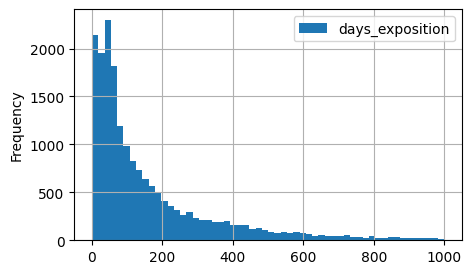

In [71]:
df.plot(y = 'days_exposition', kind = 'hist', bins = 56, grid=True, figsize = (5,3),range=(1,1000))

На гистограмме видно сильно выделяющееся значение, очевидно что это 95 дней - медианное значение количества дней размещения объявления о продаже недвижимости. В целом гистогрограмма нормального распределения. Количество объявлений уменьшается с увелечением количества дней публикации объявления.
Посмотрим на долгие продажи недвижимости, где количество дней опубликованного объявлений более 1000.




In [72]:
df.query('days_exposition > 1000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_expo,month_expo,year_expo,flat_type,cityCenters_nearest_km,disp_last_price
109,2,7497600.00,62.50,2015-12-08,2,2.65,5.00,35.50,5,NaN,...,0.00,NaN,1048.00,119961.60,1,12,2015,последний,27.00,7.50
353,4,5990000.00,43.50,2015-05-08,1,3.00,5.00,25.00,4,NaN,...,0.00,NaN,1292.00,137701.15,4,5,2015,другой,10.00,5.99
398,7,12789000.00,79.30,2014-12-09,2,3.00,8.00,43.10,5,False,...,0.00,NaN,1345.00,161273.64,1,12,2014,другой,11.00,12.79
437,12,3350000.00,37.00,2015-02-24,1,2.55,6.00,17.80,6,NaN,...,1.00,755.00,1273.00,90540.54,1,2,2015,последний,34.00,3.35
459,13,5200000.00,51.00,2016-03-02,2,2.55,9.00,32.00,5,NaN,...,0.00,NaN,1153.00,101960.78,2,3,2016,другой,16.00,5.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23248,5,4900000.00,80.00,2014-12-25,3,2.65,15.00,47.00,14,NaN,...,NaN,NaN,1187.00,61250.00,3,12,2014,другой,NaN,4.90
23318,6,5620020.00,82.30,2015-03-10,3,2.70,21.00,45.60,12,NaN,...,1.00,31.00,1200.00,68287.00,1,3,2015,другой,17.00,5.62
23389,6,2850000.00,40.00,2015-01-26,1,2.60,10.00,19.00,8,False,...,NaN,NaN,1012.00,71250.00,0,1,2015,другой,NaN,2.85
23426,17,8778000.00,47.50,2014-12-29,1,3.00,7.00,NaN,4,NaN,...,3.00,204.00,1360.00,184800.00,0,12,2014,другой,10.00,8.78


276 объявлений с "долгими продажами", это чуть более 1% от всего ДатаФрейма.

Взгляну на среднее значение количества дней публикации объявления.

In [73]:
df['days_exposition'].mean()

171.95217090928415

Посмотрю на медианное значение количества дней публикации объявления.

In [74]:
df['days_exposition'].median()

91.0

Медианное значение отличается от среднего это говорит о наличии выбросов или необычных значениях такие как слишком большое количество дней продаж

Посмотрю на зависимость количества дней опубликованного объявления от стоимости недвижимости за квадратный метр и общей площади недвижимости.

In [75]:
corr_day_exp_tot_area = df['days_exposition'].corr(df['total_area'])
corr_day_exp_sq_m_price  = df['days_exposition'].corr(df['square_meter_price'])
print('Корреляция между количеством дней опубликованного объявления и общей площадью:', corr_day_exp_tot_area )
print('Корреляция между количеством дней опубликованного объявления и ценой за квадртный метр:', corr_day_exp_sq_m_price )

Корреляция между количеством дней опубликованного объявления и общей площадью: 0.104142636136911
Корреляция между количеством дней опубликованного объявления и ценой за квадртный метр: -0.0004813059990395194


Изучив столбец "Количество дней опубликованного объявления (от публикации до снятия)" можно подметить следующее:


1.   50% квартир от всего ДатаФрейма продавалось менее 91 день;
2.   Присутсвуют объявления, которые были опубликованы более 2.5 лет, их менее 2 % от всего ДатаФрейма.
3.   Общая площадь недвижимости слабо влияет на количество дней опубликованного объявления, еще меньше влияет цена за квадратный метр продаваемой недвижимости.


> Исходя из этого можно ответить на вопросы:


1.   Обычное время продажи недвижимости - 91 день
2.   Быстрыми продажами можно считать объявления которые были опубликованы менее 91 дня.
3.   Необычно долгими продажами можно считать объявления, которые которые были опубликованы более 1000 дней.







Следующий вопрос который я исследую это зависимость цены от некоторых параметров объявления. Первый параметр это: общая площадь.

Text(0.5, 1.0, 'Зависимость цены от общей площади. Корреляция: 0.69,')

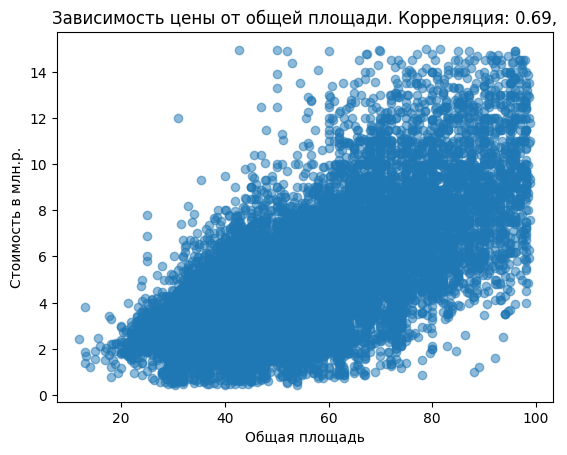

In [76]:
df = df.sort_values(by='total_area')
x = df['total_area']
y = df['disp_last_price']
corr=df['total_area'].corr(df['disp_last_price'])
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Общая площадь')
plt.ylabel('Стоимость в млн.р.')
plt.title(f'Зависимость цены от общей площади. Корреляция: {corr:.2f},')

Видна прямая, но не полная корреляция: значения цены увеличивается по мере увеличения общая площади недвижимости.
<br> Следующий параметр исследования это жилая площадь.

Text(0.5, 1.0, 'Зависимость цены от жилой площади. Корреляция: 0.54')

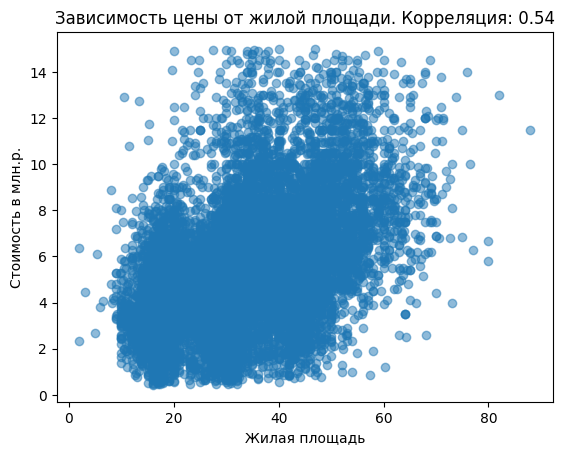

In [77]:
df = df.sort_values(by='living_area')
x = df['living_area']
y = df['disp_last_price']
corr=df['living_area'].corr(df['disp_last_price'])
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Жилая площадь')
plt.ylabel('Стоимость в млн.р.')
plt.title(f'Зависимость цены от жилой площади. Корреляция: {corr:.2f}')

Также вызовем метод `corr()`

In [78]:
df['living_area'].corr(df['disp_last_price'])

0.54234382267349

Прямая корреляция также присутсвует. С увеличением жилой площади в объявлении увеличивается цена, что в принципе является логичным процессом. Рассмотрю влияние цены на площадь кухни в объявлении о продаже недвижимости.


Text(0.5, 1.0, 'Зависимость цены от жилой площади. Корреляция: 0.50')

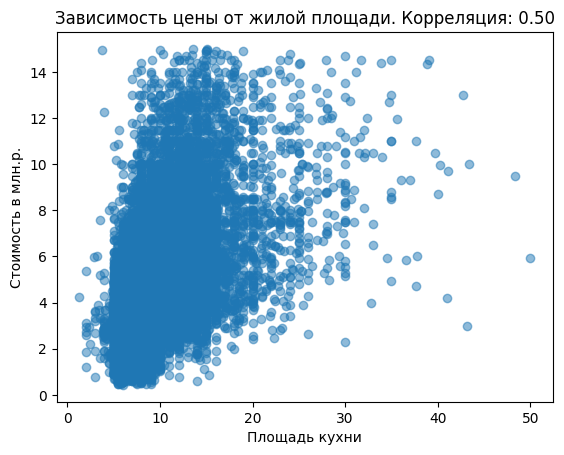

In [79]:
kitchen_area_last_price = df.pivot_table(index='kitchen_area', values='disp_last_price', aggfunc='median')
df = df.sort_values(by='kitchen_area')
x = df['kitchen_area']
y = df['disp_last_price']
corr=df['kitchen_area'].corr(df['disp_last_price'])
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость в млн.р.')
plt.title(f'Зависимость цены от жилой площади. Корреляция: {corr:.2f}')

Зависимость цены от площади кухни также присутсвует. Посмотрим зависит ли цена от количества комнат в продаваемой недвижимости.

Text(0.5, 1.0, 'Зависимость цены от кол-во комнат. Корреляция: 0.40')

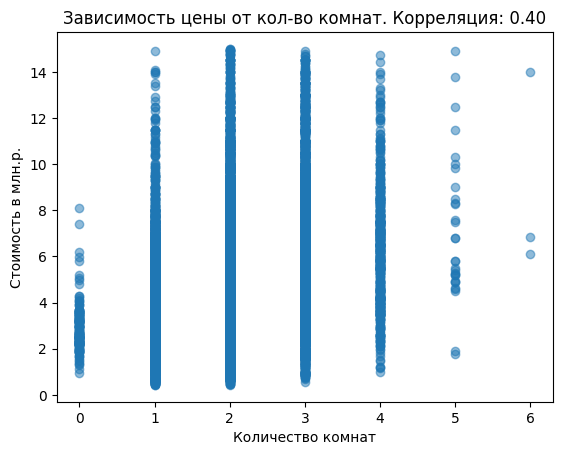

In [80]:
room_last_price = df.pivot_table(index = 'rooms', values = 'disp_last_price', aggfunc = 'median')
x = df['rooms']
y = df['disp_last_price']
corr=df['rooms'].corr(df['disp_last_price'])
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость в млн.р.')
plt.title(f'Зависимость цены от кол-во комнат. Корреляция: {corr:.2f}')

Также присутствует небольшая зависимость цены от количества комнат, сильно выбиваются объявления с продаже 12-ти комнатных квартир, их стоимость свыше 40 млн.р.
<br> Посмотрю на зависимость цены от типа этажа квартиры.

Text(0.5, 1.0, 'Зависимость цены от типа этажа')

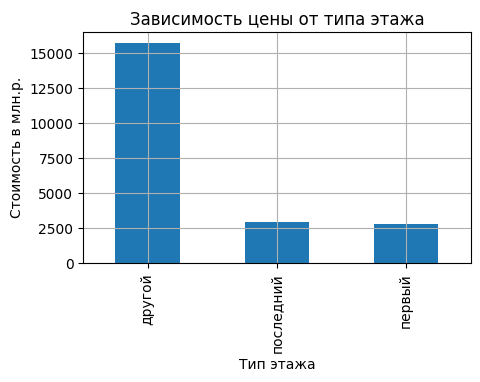

In [81]:
amount_flat_type = df['flat_type'].value_counts()
amount_flat_type.plot( kind = 'bar', grid=True, figsize = (5,3))
plt.xlabel('Тип этажа')
plt.ylabel('Стоимость в млн.р.')
plt.title('Зависимость цены от типа этажа')

Цена на квартиры, которые расположены на первых и последних этажах стоят меньше, чем остальные. Соответсвенно этаж также влияет на стоимость продаваемой недвижимости.


Text(0.5, 1.0, 'Зависимость цены от года публикации объявления')

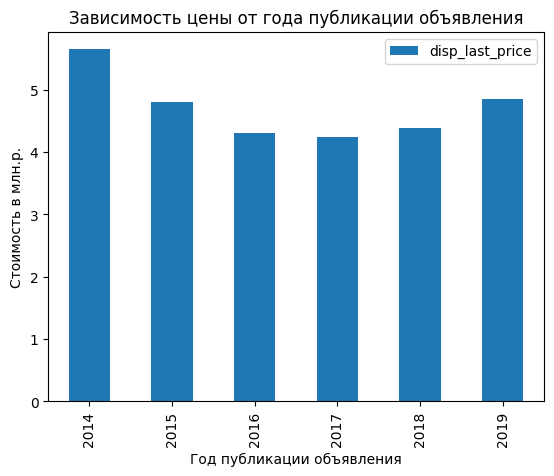

In [82]:
year_last_price = df.pivot_table(index='year_expo', values='disp_last_price', aggfunc='median')
year_last_price.plot(kind='bar')
plt.xlabel('Год публикации объявления')
plt.ylabel('Стоимость в млн.р.')
plt.title('Зависимость цены от года публикации объявления')

На данном графике видна просадка в 2016-2018 годах, в 2014-м году были опубликованы объявления с высокими ценам на недвижимость. Зависимости нет.

Text(0.5, 1.0, 'Зависимость цены от месяца публикации объявления')

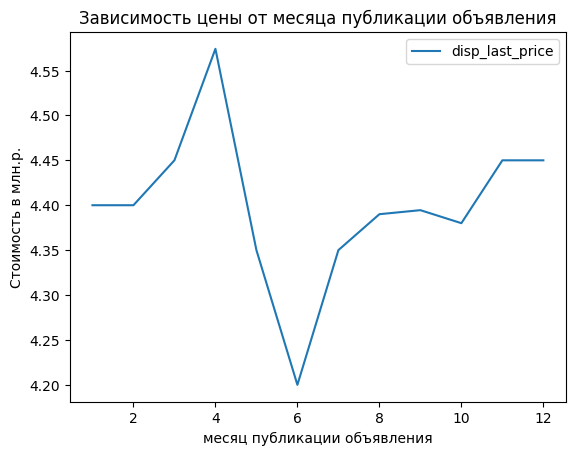

In [83]:
month_last_price = df.pivot_table(index='month_expo', values='disp_last_price', aggfunc='median')
month_last_price.plot()
plt.xlabel('месяц публикации объявления')
plt.ylabel('Стоимость в млн.р.')
plt.title('Зависимость цены от месяца публикации объявления')

График показывает что в апреле выкладывали дорогие квартиры,в то время как в июне дешевые. Зависимости нет.

Text(0.5, 1.0, 'Зависимость цены от дня публикации объявления')

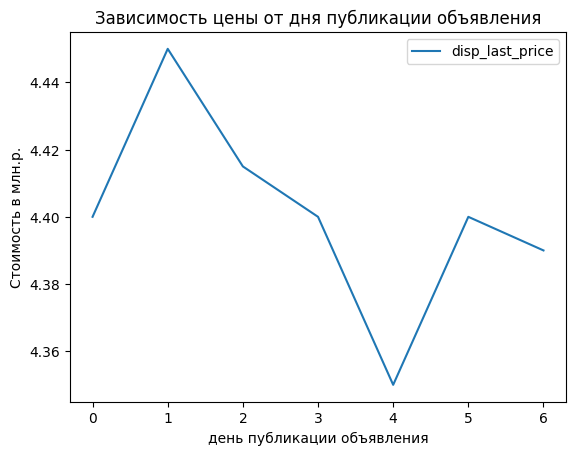

In [84]:
day_last_price = df.pivot_table(index='day_expo', values='disp_last_price', aggfunc='median')
day_last_price.plot()
plt.xlabel('день публикации объявления')
plt.ylabel('Стоимость в млн.р.')
plt.title('Зависимость цены от дня публикации объявления')

На графике видно, что объявления с дорогими квартирами выкладывались по вторник и средам. Пятницу-воскресенье выкладывались в основном квартиры с низкой ценой, вероятно из-за того, что в выходные дни выкладывалось мало объявлений и среди них не было дорогих квартир. По моему мнению прямая зависимость отсвует либо же близка к нулю.

Следующее, что я посчитаю это среднюю цены одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений.

In [85]:
popular = df['locality_name'].value_counts().head(10)
popular = popular.index.values
popular_meter_price = df.pivot_table(index='locality_name', values='square_meter_price', aggfunc='mean')
popular_meter_price = popular_meter_price.query('locality_name in @popular')
popular_meter_price.sort_values(by='square_meter_price',ascending=False)

,square_meter_price
locality_name,
Санкт-Петербург,107578.52
Пушкин,100978.09
Кудрово,95287.28
Парголово,90494.58
Мурино,86101.07
Шушары,78788.18
Колпино,75373.41
Гатчина,68938.46
Всеволожск,67170.07


На первом месте город Санкт-Петербург,1147757,5 за 1 кв.м. недвижимости, самая же низкая цена в городе Выборг, ниже почти в 2 раза чем в Санкт-Петербурге - 58238,14 за 1 кв.м.

Следующее что я изучу это квартиры в Санкт-Петербурге и вычислю каждую среднюю цену каждого километра до центра. Посмотрю как стоимость объектов зависит от расстояния до центра города.

<ipython-input-86-2fa7eb421cd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spb['price_for_1_km'] = data_spb['last_price'] / data_spb['total_area']


                        price_for_1_km
cityCenters_nearest_km                
0.00                         136645.34
1.00                         128175.37
2.00                         127939.34
3.00                         114639.48
4.00                         123810.10
5.00                         127217.47
6.00                         126827.36
7.00                         120026.80
8.00                         118932.30
9.00                         108991.70
10.00                        110017.76
11.00                        106092.53
12.00                        106486.18
13.00                        107266.67
14.00                        104025.05


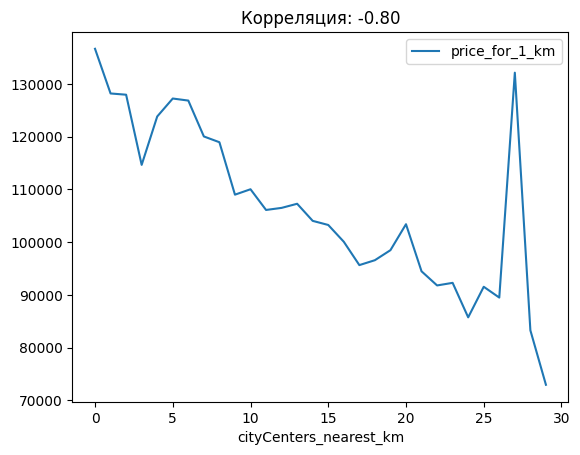

In [86]:
data_spb=df.query('locality_name=="Санкт-Петербург"')
data_spb['price_for_1_km'] = data_spb['last_price'] / data_spb['total_area']
new_spb=data_spb.loc[:,['cityCenters_nearest_km','price_for_1_km']].sort_values(by='cityCenters_nearest_km',ascending=True)
new_spb_piv=new_spb.pivot_table(index='cityCenters_nearest_km', values='price_for_1_km', aggfunc='mean')
print(new_spb_piv.head(15))
new_spb_piv = new_spb_piv.reset_index()
corr=new_spb_piv['cityCenters_nearest_km'].corr(new_spb_piv['price_for_1_km'])
new_spb_piv.plot(x='cityCenters_nearest_km', y='price_for_1_km', kind='line')
plt.title(f'Корреляция: {corr:.2f}')
plt.show()

И так есть стоимость недвижимости за 1 кв.м. на каждом километре от центра г.Санкт-Петербурга. Построил график корреляции и увидел прямую обратную линейную связь, то есть чем меньше расстояние до центра, тем выше цена за квадратный метр.Хотя присутствуют и исключения, например в 26 и 6 км. от центра города.

#Общий вывод:
<br>Цель данного исследования – выполнить предобработку данных и изучить их, найти интересные особенности.
В ходе исследования было обнаружено большое количество пропусков, как в данных, добавленных пользователем, так и в картографических, часть из них мы заменили на медианные значения, часть из них удалили вообще. Избавили от неявных дубликатов в столбце "Название населенного пункта". Убрали редкие и выбивающиеся значения. Добавили новые столбцы, которые были получены в результате арифметических действий данных из имеющихся столбцов. Ещё добавили столбцы с сгруппированными данными, например тип этажа квартиры.
Провели исследовательский анализ данных описали все наблюдения по каждому столбцу. Изучили как быстро продавались квартиры, посчитали какие продажи быстрые, а какие продажи необычно долгие.
Изучили какие факторы влияют на общую(полную) стоимость объекта.
Посчитали среднюю цену квадратного метра в 10 населенных пунктах с наибольшим числом объявлений. Выделили населенные пункты с самой высокой и самой низкой ценой за квадратный метр.
Высчитали среднюю цену за квадратный метр на каждом километре от центра Санкт-Петербурга.
Выявили следующие закономерности и особенности:
1.	Цена зависит от площади недвижимости: общей, жилой и площадью кухни. Площадь квартиры является одним из самых важных критериев при определении ее стоимости. Это связано с тем, что более просторные квартиры, как правило, имеют более высокую стоимость, чем менее просторные. Прежде всего, площадь квартиры напрямую влияет на количество комнат и общую площадь. Большая квартира может иметь большее количество комнат, что делает ее более привлекательной для больших семей или людей, которые нуждаются в дополнительном пространстве для работы или хобби.
2.	В Санкт-Петербурге так же цена зависит от дальности к центру города, чем ближе к центру, тем дороже квадратный метр. Центр города обычно является основным местом бизнеса, культурной и социальной жизни, торговли и развлечений. Поэтому квартиры, расположенные ближе к центру города, имеют ряд преимуществ, которые делают их более дорогими: удобство транспорта, престижность и статус, большое количество развлечений и магазинов, высокие спрос и ликвидность квартиры;
3.	40 % объявлений о продаже недвижимости в типовых застройках (5-ти и 9-ти этажные дома). Вероятно, это так называемые «сталинки», «хрущевки» и «брежневки» являющиеся наследием Советского Союза — это жилые многоквартирные дома, которые были построены в период с 1950-х по 1980-е годы.
4.	30% опубликованной недвижимости, расположена менее чем в 1 км от парков. Это говорит о большом количестве парков в Санкт-Петербурге и Ленинградской области.
Исследование могло быть более объективным и точным, если бы не присутствовали в пропуски в столбцах, особенно важный столбец это количество дней опубликованной объявления с момента публикации до момента снятия.
<br>
<br> Исследование могло быть более объективным и точным, если бы не присутствовали в пропуски в столбцах, особенно важный столбец это количество дней опубликованной объявления с момента публикации до момента снятия.
